# Backpack Kaggle Competition
### W207 Final Project - Spring 2025

Team: Perry Gabriel, Aurelia Yang

University of California, Berkeley

## Description

In this competition, participants are challenged to develop machine learning models to predict the price of a backpack based on various features. This is a great opportunity to test your skills, learn new techniques, and compete with others in the data science community.

## Evaluation

Submissions are evaluated on the root mean squared error between the predicted and actual price of the backpack.

RMSE is defined as:
$$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$

where $y_i$ is the actual price of the backpack and $\hat{y}_i$ is the predicted price of the backpack.

## Data Description

The data consists of the following columns:

- `id`: A unique identifier for the backpack.
- `Brand`: The brand of the backpack.
- `Material`: The material of the backpack.
- `Size`: The size of the backpack.
- `Compartments`: The number of compartments in the backpack.
- `Laptop Compartment`: Whether the backpack has a laptop compartment.
- `Waterproof`: Whether the backpack is waterproof.
- `Style`: The style of the backpack.
- `Color`: The color of the backpack.
- `Weight Capacity (kg)`: The weight capacity of the backpack in kilograms.
- `Price`: The price of the backpack.

## Data Splits
The dataset is split into three parts:
- **Train**: The training set contains 80% of the data and is used to train the model.
- **Validation**: The validation set contains 10% of the data and is used to tune the model.
- **Test**: The test set contains 10% of the data and is used to evaluate the model's performance.

## Important Notes about the Dataset
- There are (4) different datasets: train, train_extra, test, and sample_submission.
- The `train` dataset contains the training data with the target variable `Price`.
- The `train_extra` dataset contains additional training data that can be used to improve the model's performance.
- The `test` dataset contains the test data without the target variable `Price`.
- The `sample_submission` dataset contains a sample submission file with the correct format.
- The `train` and `train_extra` datasets are combined to create a larger training set.
- The `train_extra` dataset was provided by the competition organizers and is not part of the original dataset.

## Submission File

For each `id` in the test set, you must predict the price of the backpack. The file should contain a header and have the following format:

```python
id,Price
1,100
2,200
3,300
```

## Timeline

- **Start Date** - February 1, 2025
- **Entry Deadline** - Same as the Final Submission Deadline
- **Team Merger Deadline** - Same as the Final Submission Deadline
- **Final Submission Deadline** - February 28, 2025

All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

## Acknowledgements

This dataset was created by [Kaggle](https://www.kaggle.com/datasets/souradippal/student-bag-price-prediction-dataset) for the purpose of hosting a competition.

## Team Members

- [Perry Gabriel](https://www.kaggle.com/prgabriel)
- [Aurelia Yang](https://www.kaggle.com/aureliayang)

## Sections

1. [Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)
2. [Data Preprocessing](#2.-Data-Preprocessing)
3. [Modeling](#3.-Modeling)
4. [Evaluation](#4.-Evaluation)
5. [Optimization](#5.-Optimization)
6. [Final Submission](#6.-Final-Submission)
7. [Conclusion](#7.-Conclusion)

## References
[Backpack Kaggle Competition Link](https://www.kaggle.com/competitions/playground-series-s5e2)

[Backpack Kaggle Competition Dataset](https://www.kaggle.com/datasets/souradippal/student-bag-price-prediction-dataset)


## 0. Setup
Install the required libraries
Uncomment to download the data from Kaggle. This assumes you have the Kaggle API installed and configured.

In [49]:
# !kaggle competitions download -c playground-series-s5e2
# !unzip playground-series-s5e2 -d ../data/raw/
# !pip install -r ../requirements.txt
# !rm -rf playground-series-s5e2.zip

In [50]:
!pip install mlflow
!pip install category_encoders


import os
import mlflow
import numpy as np
import pandas as pd
import xgboost as xgb
import mlflow.sklearn
import mlflow.xgboost
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning.

In [51]:
#mlflow.set_tracking_uri("http://127.0.0.1:5000")
#mlflow.set_experiment(experiment_name='E2E_Kaggle_Backpack_Project')
#mlflow.autolog()

In [52]:
raw_data_path = '../data/raw/'

In [53]:
#%pip install google.colab

def check_and_import_colab():
    global raw_data_path
    global processed_path
    try:
        from google.colab import drive
        import google.colab
        print("Running on Google Colab")
        # Import necessary libraries for Google Colab
        drive.mount('/content/drive')

        # define paths
        raw_data_path = "/content/drive/MyDrive/Kaggle_Backpack/data/raw/"
        processed_path = "/content/drive/MyDrive/Kaggle_Backpack/data/processed/"
        return True

    except ImportError:
        print("Not running on Google Colab")
        os.makedirs(raw_data_path, exist_ok=True)
        print("Created 'raw_data_path' directory for non-Colab Environment.")
        return False

on_colab = check_and_import_colab()

Running on Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Exploratory Data Analysis

In this section, we will explore the data to understand its structure and identify any patterns or trends that may be present.


### 1.1 Load the Data

Let's start by loading the data and taking a look at the first few rows.

In [54]:
train_df = pd.read_csv(filepath_or_buffer=os.path.join(raw_data_path, 'train.csv'), index_col=0, header=0, sep=',')
test_df = pd.read_csv(filepath_or_buffer=os.path.join(raw_data_path, 'test.csv'), index_col=0, header=0, sep=',')
train_extra_df = pd.read_csv(filepath_or_buffer=os.path.join(raw_data_path, 'training_extra.csv'), index_col=0, header=0, sep=',')

train_df.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [55]:
test_df.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
id,,,,,,,,,
300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


In [56]:
train_extra_df.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
500000,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052,114.11068
500001,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095,129.74972
500002,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302,21.37370
500003,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581,48.09209
500004,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826,77.32461


### 1.2 Data Summary

Next, let's take a look at the summary statistics of the data.


In [57]:
# Display the summary statistics of the training data
train_df.describe()

,Compartments,Weight Capacity (kg),Price
count,300000.000000,299862.000000,300000.000000
mean,5.443590,18.029994,81.411107
std,2.890766,6.966914,39.039340
min,1.000000,5.000000,15.000000
25%,3.000000,12.097867,47.384620
50%,5.000000,18.068614,80.956120
75%,8.000000,24.002375,115.018160
max,10.000000,30.000000,150.000000


In [58]:
test_df.describe()

,Compartments,Weight Capacity (kg)
count,200000.000000,199923.000000
mean,5.442855,17.993033
std,2.888740,6.972079
min,1.000000,5.000000
25%,3.000000,12.068875
50%,5.000000,18.054750
75%,8.000000,23.965700
max,10.000000,30.000000


In [59]:
train_extra_df.describe()

,Compartments,Weight Capacity (kg),Price
count,3.694318e+06,3.692648e+06,3.694318e+06
mean,5.434022e+00,1.800883e+01,8.135820e+01
std,2.893227e+00,6.974541e+00,3.893050e+01
min,1.000000e+00,5.000000e+00,1.500000e+01
25%,3.000000e+00,1.206854e+01,4.747778e+01
50%,5.000000e+00,1.805243e+01,8.098592e+01
75%,8.000000e+00,2.398580e+01,1.148434e+02
max,1.000000e+01,3.000000e+01,1.500000e+02


Let's see the data types of each column.

In [60]:
print(f"Data types of columns in training dataset\n{train_df.dtypes}\n")
print(f"Data types of columns in training extra dataset\n{train_extra_df.dtypes}\n")
print(f"Data types of columns in testing dataset\n{test_df.dtypes}\n")

Data types of columns in training dataset
Brand                    object
Material                 object
Size                     object
Compartments            float64
Laptop Compartment       object
Waterproof               object
Style                    object
Color                    object
Weight Capacity (kg)    float64
Price                   float64
dtype: object

Data types of columns in training extra dataset
Brand                    object
Material                 object
Size                     object
Compartments            float64
Laptop Compartment       object
Waterproof               object
Style                    object
Color                    object
Weight Capacity (kg)    float64
Price                   float64
dtype: object

Data types of columns in testing dataset
Brand                    object
Material                 object
Size                     object
Compartments            float64
Laptop Compartment       object
Waterproof               object
Style  

Let's get the shape of the data.

In [61]:
# Display the shape of the dataset.
print(f"Shape of training data: {train_df.shape}")
print(f"Shape of training extra data: {train_extra_df.shape}")
print(f"Shape of testing data: {test_df.shape}")

Shape of training data: (300000, 10)
Shape of training extra data: (3694318, 10)
Shape of testing data: (200000, 9)


#### Combine the train and train_extra datasets

Now, let's combine the train and train_extra datasets to create a larger training set.

In [62]:
# Combine train and train_extra datasets
train_df = pd.concat([train_df, train_extra_df], axis=0).reset_index(drop=True)

# Display the shape of the combined dataset
print(f"Shape of combined training data: {train_df.shape}")

# Display the shape of the combined dataset
train_df.shape

# Display the first few rows of the combined dataset
train_df.head()


Shape of combined training data: (3994318, 10)


,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


Let's capture the categories of the categorical variables.

In [63]:
cat_columns = train_df.columns[:-2].tolist()  # Dropped the last two columns since we know that these are numerical columns
print(f'There are {len(cat_columns)} categorical columns:')
print(cat_columns)

num_columns = [train_df.columns[-2]]
print(f'There are {len(num_columns)} numerical column:')
print(num_columns)

There are 8 categorical columns:
['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
There are 1 numerical column:
['Weight Capacity (kg)']


### 1.3 Data Visualization

We created visualizations to better understand the data.


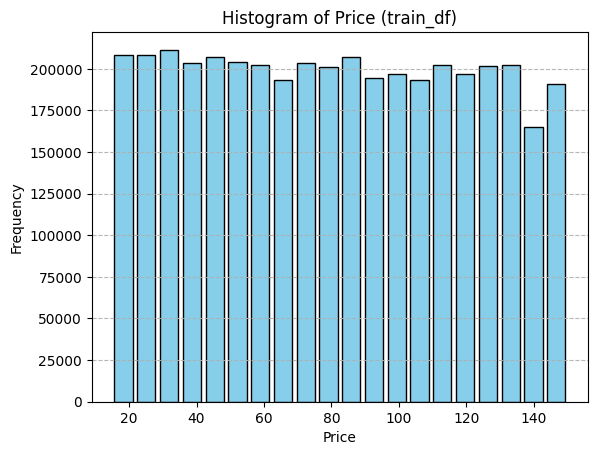

In [64]:
# For example, plot a histogram of the price column
plt.hist(train_df['Price'], bins=20, edgecolor='black', color='skyblue', rwidth=0.8)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Price (train_df)')
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.show()

### 1.4 Correlation Matrix

Finally, let's create a correlation matrix to see how the features are related to each other.


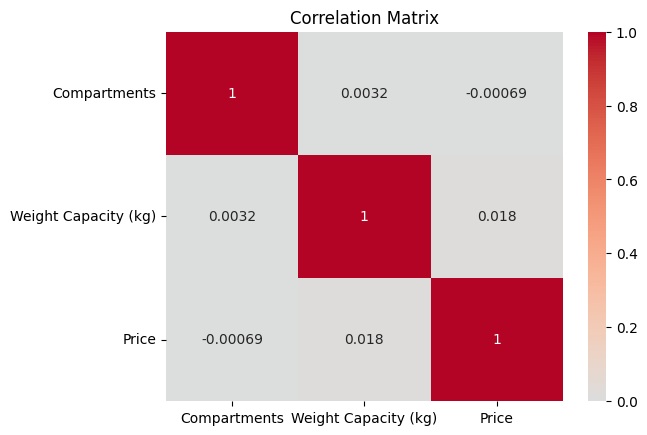

In [65]:
# select numeric columns
numeric_cols = train_df.select_dtypes(include=['float64', 'int64'])

# create a cm
corr = numeric_cols.corr()

# correlation matrix with center=0
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

### Observations so far:

- `training_extra` has significantly more records (3.69M) than `training` (300k), which will be useful in improving model training.
- Some categorical columns have substantial missing values:
    - `Brand`: 9705 missing in `train`, 117,000 missing in `train_extra`
    - `Material`, `Style`, `Color`
- `train_extra` has a higher proportion of missing values.
- Considering:
    - Mode imputation for categorical columns
    - Mean/median imputation for numerical columns


### 1.5 Feature Distribution

Let's take a look at the distribution of the features.

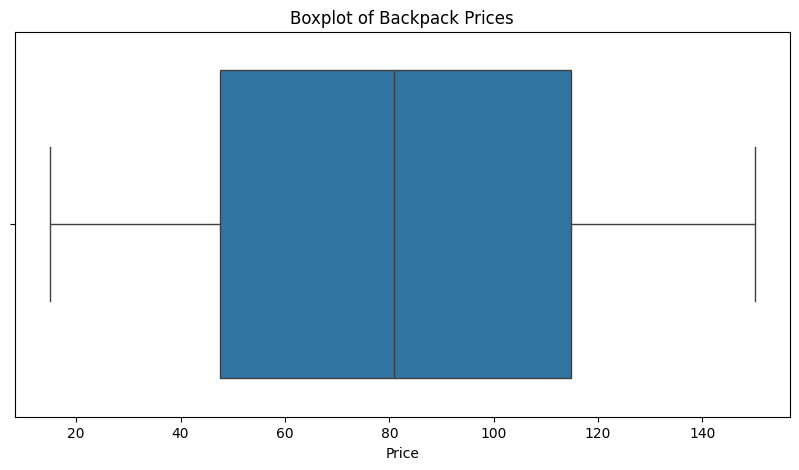

In [66]:
# outlier boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(x=train_df["Price"])
plt.title("Boxplot of Backpack Prices")
plt.show()

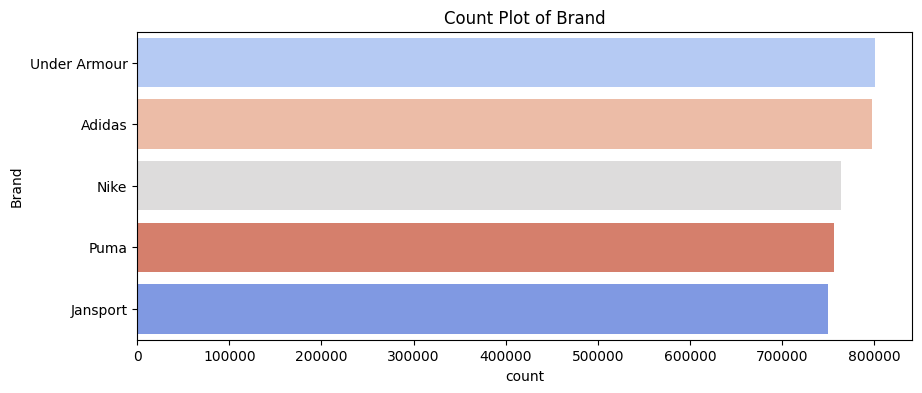

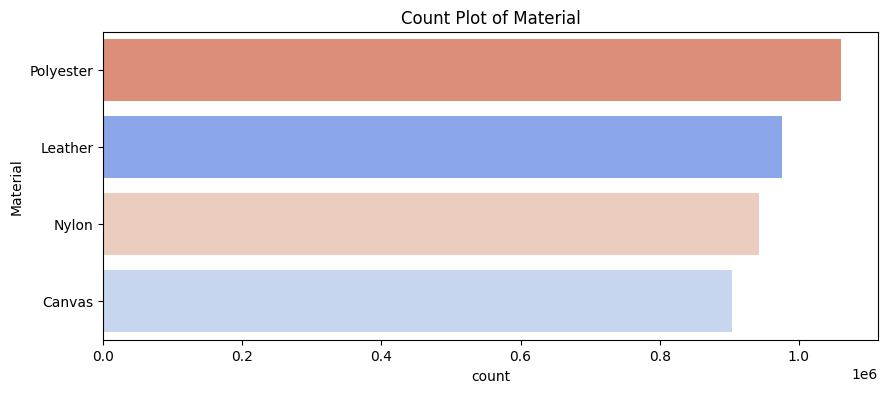

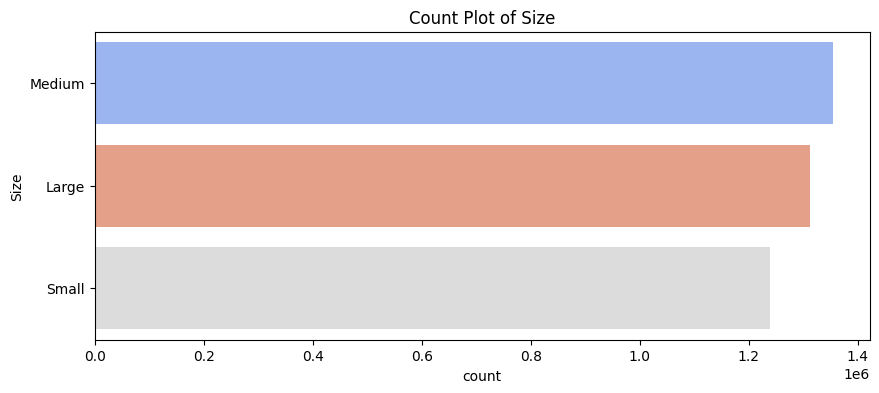

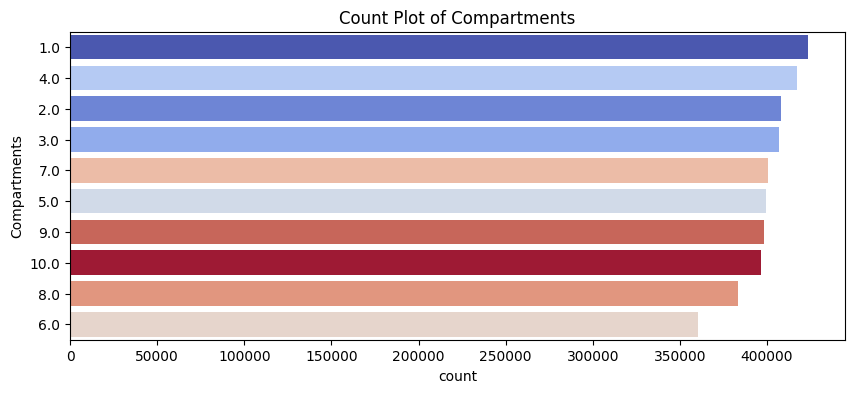

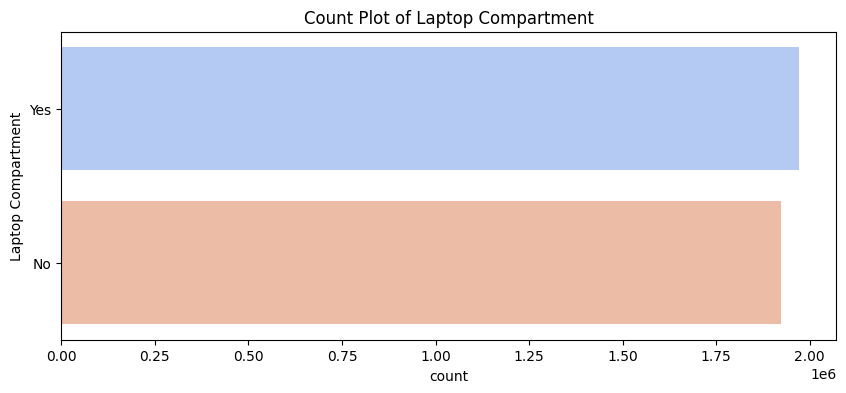

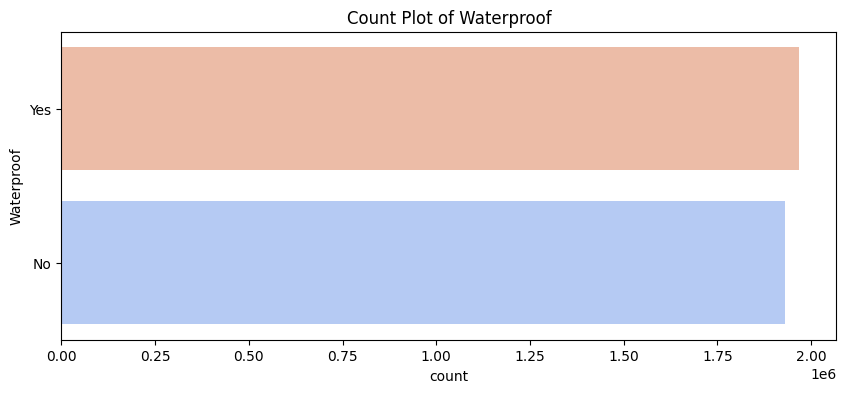

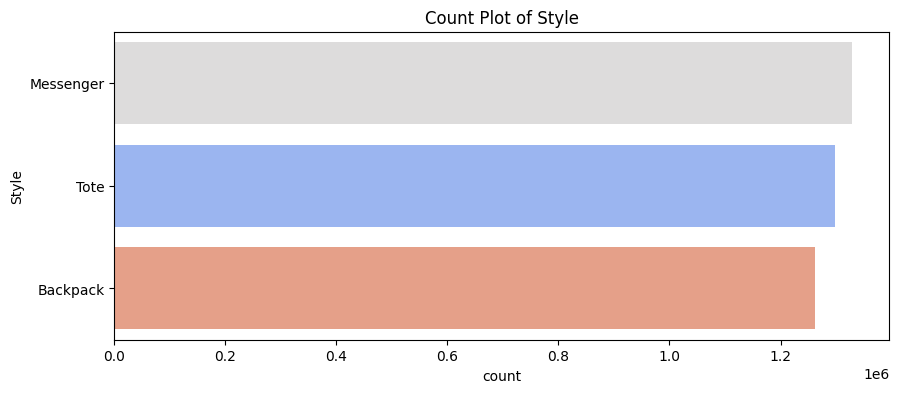

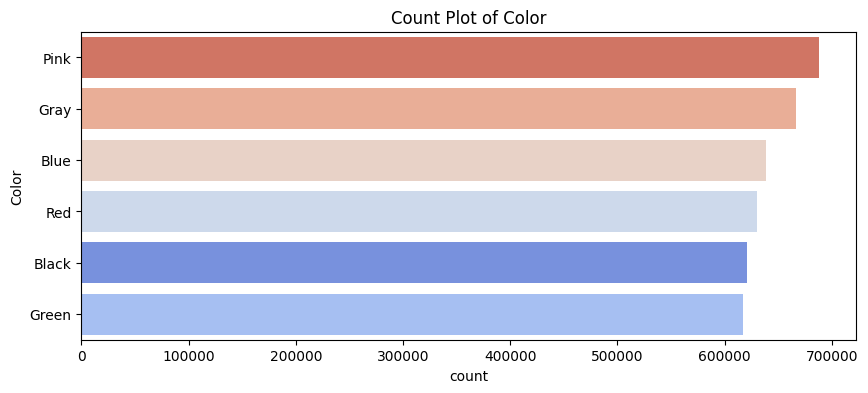

In [67]:
# categorical feature distribution
for col in cat_columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(y=train_df[col], order=train_df[col].value_counts().index, hue=train_df[col], palette="coolwarm", legend=False)
    plt.title(f"Count Plot of {col}")
    plt.show()


## 2. Data Preprocessing

In this section, we will preprocess the data to prepare it for modeling.

### 2.1 Feature Engineering

In this section, we will create new features that may help improve the performance of our models.


#### Creation of Combined (Combined_list) Features

For each original categorical column, a new feature is generated by combining it with `Weight Capacity`.

This is done to create a new feature that captures the interaction between the original categorical feature and the weight capacity of the backpack. The new feature is created by multiplying the weight capacity by 100 and adding it to the original categorical feature. This allows us to create a new feature that captures the interaction between the original categorical feature and the weight capacity of the backpack.

In [68]:

# COMMENTED OUT FEATURE ENGINEERING COMBINING CATEGORY + NUMERIC
# Reason: This transformation was adding encoded category + (100 * weight capacity), which may not be meaningful and is discouraged by shuri

# combined_list = []
# label_encoders = {}

# for c in cat_columns:  # Use 'cat_columns' as defined earlier in the notebook
#     # Initialize and fit a LabelEncoder for the current column
#     le = LabelEncoder()
#     combined = pd.concat([train_df[c], test_df[c]], axis=0)
#     le.fit(combined)
#     label_encoders[c] = le  # Store the encoder for potential future use

#     # Transform the train and test data
#     train_df[c] = le.transform(train_df[c])
#     test_df[c] = le.transform(test_df[c])

#     # Create a new column combining the encoded value and weight capacity
#     new_col = f"{c}_Weight_Capacity_Combined"
#     train_df[new_col] = train_df[c] * 100 + train_df["Weight Capacity (kg)"]
#     test_df[new_col] = test_df[c] * 100 + test_df["Weight Capacity (kg)"]

#     # Append the new column name to the combined_list list
#     combined_list.append(new_col)

# print(f"We now have {len(combined_list)} new columns")
# print(combined_list)


'\nCOMMENTED OUT FEATURE ENGINEERING COMBINING CATEGORY + NUMERIC\nReason: This transformation was adding encoded category + (100 * weight capacity), which may not be meaningful and is discouraged by the professor.\n\ncombined_list = []\nlabel_encoders = {}\n\nfor c in cat_columns:  # Use \'cat_columns\' as defined earlier in the notebook\n    # Initialize and fit a LabelEncoder for the current column\n    le = LabelEncoder()\n    combined = pd.concat([train_df[c], test_df[c]], axis=0)\n    le.fit(combined)\n    label_encoders[c] = le  # Store the encoder for potential future use\n\n    # Transform the train and test data\n    train_df[c] = le.transform(train_df[c])\n    test_df[c] = le.transform(test_df[c])\n\n    # Create a new column combining the encoded value and weight capacity\n    new_col = f"{c}_Weight_Capacity_Combined"\n    train_df[new_col] = train_df[c] * 100 + train_df["Weight Capacity (kg)"]\n    test_df[new_col] = test_df[c] * 100 + test_df["Weight Capacity (kg)"]\n\n  

In [72]:
input_variables = cat_columns + num_columns
print(f"We now have {len(input_variables)} columns:")
print(input_variables)

We now have 9 columns:
['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)']


In [75]:
# Define the input features and target variable
X = train_df[input_variables]
y = train_df['Price']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# For the test dataset (test.csv), ensure it only contains the input features
X_test_final = test_df[input_variables]

# Display the shapes of the datasets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_test_final shape: {X_test_final.shape}")

X_train shape: (2796022, 9)
y_train shape: (2796022,)
X_valid shape: (599148, 9)
y_valid shape: (599148,)
X_test shape: (599148, 9)
y_test shape: (599148,)
X_test_final shape: (200000, 9)


## 3. Modeling

In this section, we will select and train machine learning models to predict the price of the backpack.

First, let's properly impute missing values in numerical and categorical columns. We will compare 2 methods for numerical: KNNIMputer and SimpleImputer with median.

In [78]:
def evaluate_imputation_strategy(imputer, X_train, X_valid):
    """
    Fits imputer on X_train, transforms X_valid,
    encodes categoricals, trains a linear regression,
    and returns validation MAE.
    """
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_absolute_error
    from copy import deepcopy

    # deep copy
    X_train_copy = deepcopy(X_train)
    X_valid_copy = deepcopy(X_valid)

    # separate numeric and categorical columns
    numeric_cols = X_train_copy.select_dtypes(include=[np.number]).columns
    cat_cols = X_train_copy.select_dtypes(exclude=[np.number]).columns

    # 1. numeric imputation
    X_train_copy[numeric_cols] = imputer.fit_transform(X_train_copy[numeric_cols])
    X_valid_copy[numeric_cols] = imputer.transform(X_valid_copy[numeric_cols])

    # 2. fill categorical missing values
    X_train_copy[cat_cols] = X_train_copy[cat_cols].fillna("Missing")
    X_valid_copy[cat_cols] = X_valid_copy[cat_cols].fillna("Missing")

    # 3. one-hot encode categorical columns
    X_train_copy = pd.get_dummies(X_train_copy, columns=cat_cols)
    X_valid_copy = pd.get_dummies(X_valid_copy, columns=cat_cols)

    # 4. align columns (to match dummy columns between sets)
    X_train_copy, X_valid_copy = X_train_copy.align(X_valid_copy, join='left', axis=1)
    X_valid_copy = X_valid_copy.fillna(0)

    # 5. train and evaluate
    model = LinearRegression()
    model.fit(X_train_copy, y_train)
    y_pred = model.predict(X_valid_copy)
    mae = mean_absolute_error(y_valid, y_pred)
    return mae

simple_median_imputer = SimpleImputer(strategy='median')
mae_median = evaluate_imputation_strategy(simple_median_imputer, X_train, X_valid)

knn_imputer = KNNImputer(n_neighbors=5)
mae_knn = evaluate_imputation_strategy(knn_imputer, X_train, X_valid)

print("MAE with Median Imputer:", mae_median)
print("MAE with KNN Imputer:", mae_knn)

MAE with Median Imputer: 33.616664852392475
MAE with KNN Imputer: 33.61666548011236


They both have the same MAE, so we will go ahead with the median approach, as it is simpler and faster at scale.

In [81]:
# Separate numeric vs. categorical columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns

# Fill numeric columns with X_train's median
numeric_imputer = SimpleImputer(strategy='median')
X_train[numeric_cols] = numeric_imputer.fit_transform(X_train[numeric_cols])
X_valid[numeric_cols] = numeric_imputer.transform(X_valid[numeric_cols])
X_test[numeric_cols] = numeric_imputer.transform(X_test[numeric_cols])

# Fill categorical columns with "Missing"
X_train[cat_cols] = X_train[cat_cols].fillna("Missing")
X_valid[cat_cols] = X_valid[cat_cols].fillna("Missing")
X_test[cat_cols] = X_test[cat_cols].fillna("Missing")

Now we will standardize numeric features.

In [82]:
# numeric standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# fit on X_train numeric features
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_valid[numeric_cols] = scaler.transform(X_valid[numeric_cols])
X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])

# (Optional) If we use X_test_final for Kaggle submission
#X_test_final[numeric_cols] = scaler.transform(X_test_final[numeric_cols])

And perform one-hot encoding on the categorical variables.

In [83]:
# One Hot Encoding
from sklearn.preprocessing import OneHotEncoder

# instantiate the encoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# fit on train's categorical columns
ohe.fit(X_train[cat_cols])

# transform each dataset's categorical columns
X_train_ohe = ohe.transform(X_train[cat_cols])
X_valid_ohe = ohe.transform(X_valid[cat_cols])
X_test_ohe  = ohe.transform(X_test[cat_cols])

# convert numeric columns to arrays
X_train_numeric = X_train[numeric_cols].values
X_valid_numeric = X_valid[numeric_cols].values
X_test_numeric  = X_test[numeric_cols].values

# concatenate numeric and encoded categorical data
X_train_final = np.concatenate([X_train_numeric, X_train_ohe], axis=1)
X_valid_final = np.concatenate([X_valid_numeric, X_valid_ohe], axis=1)
X_test_final_2 = np.concatenate([X_test_numeric, X_test_ohe], axis=1)

# reminder: if we want to make final Kaggle submissions on test_df,
# we need to transform X_test_final the same way, if it exists.
# e.g.
# X_test_final_ohe = ohe.transform(X_test_final[cat_cols])
# X_test_final_numeric = X_test_final[numeric_cols].values
# X_test_final_new = np.concatenate([X_test_final_numeric, X_test_final_ohe], axis=1)

**IMPORTANT NOTE TO SELF:**
Make the same changes for XGBoost as well, or any other model you train. For example:

xgb_regressor.fit(X_train_final, y_train, eval_set=[(X_train_final, y_train), (X_valid_final, y_valid)], verbose=15)
...
y_pred_test_xgb = xgb_regressor.predict(X_test_final_2)

Otherwise, we'll be mixing data that’s not one-hot-encoded for XGBoost.

## 2.1 Baseline Models

Linear Regresion model

In [84]:
# Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_final, y_train)

# Make predictions on the validation set
y_pred_lr = lr_model.predict(X_valid_final)

# Make predictions on the test set
y_pred_test_lr = lr_model.predict(X_test_final_2)

# Display the first few predictions
print("First few predictions on the test set:", y_pred_test_lr[:5])

First few predictions on the test set: [81.66358644 81.49841174 81.75388688 82.96322064 84.13022288]


XGBoost model

In [85]:
# Convert the one-hot encoded data into DMatrix format
dtrain = xgb.DMatrix(X_train_final, label=y_train)
dvalid = xgb.DMatrix(X_valid_final, label=y_valid)
dtest = xgb.DMatrix(X_test_final_2)

# Define the parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model
evals = [(dtrain, 'train'), (dvalid, 'valid')]
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=15
)

# Make predictions
y_pred_valid = xgb_model.predict(dvalid)
y_pred_test = xgb_model.predict(dtest)

print("First few predictions on the test set:", y_pred_test[:5])

[0]	train-rmse:38.95048	valid-rmse:38.89914
[15]	train-rmse:38.93743	valid-rmse:38.88710
[30]	train-rmse:38.92619	valid-rmse:38.87705
[45]	train-rmse:38.91910	valid-rmse:38.87116
[60]	train-rmse:38.91218	valid-rmse:38.86542
[75]	train-rmse:38.90723	valid-rmse:38.86151
[90]	train-rmse:38.90273	valid-rmse:38.85807
[105]	train-rmse:38.89928	valid-rmse:38.85559
[120]	train-rmse:38.89582	valid-rmse:38.85310
[135]	train-rmse:38.89311	valid-rmse:38.85134
[150]	train-rmse:38.89067	valid-rmse:38.84996
[165]	train-rmse:38.88843	valid-rmse:38.84867
[180]	train-rmse:38.88643	valid-rmse:38.84768
[195]	train-rmse:38.88448	valid-rmse:38.84680
[210]	train-rmse:38.88265	valid-rmse:38.84615
[225]	train-rmse:38.88098	valid-rmse:38.84552
[240]	train-rmse:38.87929	valid-rmse:38.84477
[255]	train-rmse:38.87766	valid-rmse:38.84408
[270]	train-rmse:38.87618	valid-rmse:38.84365
[285]	train-rmse:38.87480	valid-rmse:38.84330
[300]	train-rmse:38.87347	valid-rmse:38.84285
[315]	train-rmse:38.87208	valid-rmse:38.84

XGBRegressor model

In [86]:
# Initialize the XGBRegressor model
xgb_regressor = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=50,
    random_state=42
)

# Train the model on the training dataset
xgb_regressor.fit(
    X_train_final,
    y_train,
    eval_set=[(X_train_final, y_train), (X_valid_final, y_valid)],
    verbose=15
)

# Make predictions on the validation set
y_pred_valid_xgb = xgb_regressor.predict(X_valid_final)

# Make predictions on the test set
y_pred_test_xgb = xgb_regressor.predict(X_test_final_2)

# Display the first few predictions
print("First few predictions on the test set:", y_pred_test_xgb[:5])

[0]	validation_0-rmse:38.95048	validation_1-rmse:38.89914
[15]	validation_0-rmse:38.93743	validation_1-rmse:38.88710
[30]	validation_0-rmse:38.92619	validation_1-rmse:38.87705
[45]	validation_0-rmse:38.91910	validation_1-rmse:38.87116
[60]	validation_0-rmse:38.91218	validation_1-rmse:38.86542
[75]	validation_0-rmse:38.90723	validation_1-rmse:38.86151
[90]	validation_0-rmse:38.90273	validation_1-rmse:38.85807
[99]	validation_0-rmse:38.90074	validation_1-rmse:38.85667
First few predictions on the test set: [81.43612  79.931816 81.73544  83.05678  82.63936 ]


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# intialize the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

# train on one-hot encoded + standardized data
rf_model.fit(X_train_final, y_train)

# predict on validation set
y_pred_valid_rf = rf_model.predict(X_valid_final)

# pred on test set
y_pred_test_rf = rf_model.predict(X_test_final_2)

# validation RMSE
rf_rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid_rf))
print(f"Random Forest Validation RMSE: {rf_rmse_valid}")


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# parameter space
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

# intialize base model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# randomized search (for speed) with cv
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=10,  # how many random combos to try (keep editing)
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    random_state=42
)

# fit on training data
random_search.fit(X_train_final, y_train)

# get best model
best_rf = random_search.best_estimator_
print("Best Random Forest params:", random_search.best_params_)

# predict on the validation set
y_pred_rf_valid = best_rf.predict(X_valid_final)
rmse_rf_valid = np.sqrt(mean_squared_error(y_valid, y_pred_rf_valid))
print("Tuned Random Forest Validation RMSE:", rmse_rf_valid)


## 4. Evaluation

In this section, we will evaluate the performance of our models using various metrics.


In [87]:
# Evaluate the xgb model using RMSE
xgb_rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
print(f"Baseline - XGBoost Validation RMSE: {xgb_rmse_valid}")

# Calculate RMSE for the validation set
xgbreg_rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid_xgb))
print(f"Baseline - XGBoost Regressor Validation RMSE: {xgbreg_rmse_valid}")

# Evaluate the linear regression model using RMSE
rmse_lr = np.sqrt(mean_squared_error(y_valid, y_pred_lr))
print(f"Baseline - Linear Regression Validation RMSE: {rmse_lr}")

Baseline - XGBoost Validation RMSE: 38.83744615679862
Baseline - XGBoost Regressor Validation RMSE: 38.856672506657546
Baseline - Linear Regression Validation RMSE: 38.87557679378637


In [88]:
import mlflow.sklearn
import mlflow.xgboost

# Log the XGBoost Booster model
mlflow.xgboost.log_model(xgb_model, artifact_path="xgb_booster_model", registered_model_name="xgb_booster_model")

# Log the XGBoost Regressor model
mlflow.sklearn.log_model(xgb_regressor, artifact_path="xgb_regressor_model", registered_model_name="xgb_regressor_model")

# Log the Linear Regression model
mlflow.sklearn.log_model(lr_model, artifact_path="linear_regression_model", registered_model_name="linear_regression_model")

print("Models logged successfully as MLflow models.")


KeyboardInterrupt: 

In [ ]:
# Save the XGBoost Booster model locally
mlflow.sklearn.save_model(xgb_model, path='../models/baseline/xgb_booster_model')

# Save the XGBoost Regressor model locally
mlflow.sklearn.save_model(xgb_regressor, path='../models/baseline/xgb_rgr_model')

# Save the Linear Regression model locally using mlflow
mlflow.sklearn.save_model(lr_model, path='../models/baseline/lr_model')

print("Models saved locally.")


In [ ]:

mlflow.end_run()



## 5. Model Optimization

In this section, we will optimize the hyperparameters of our models to improve their performance.


## 6. Final Submission

In this section, we will select the best model and make final predictions on the test set.


## 7. Conclusion

In this section, we will summarize our findings and discuss the implications of our results.

New Shuri Baseline Edits

**DONE**:
- one hot encoding categorcal
- median impute for numerical and missing for categorical
  - compared knnimpute vs median impute for numerical (same MAE on a simple linear model)
- verify/removed "multiplying weight capacity by 100" feature
- Center = 0 in Heatmap to highlight negative vs. positive correlation more clearly.
- check missing values meaning -> don't have domain-specific knowledge (confirm this?)
- standardized numeric features (inserted standardscaler step after imputing numeric cols, before ohe)

note: i moved your xgboost after the OHE for cohesion + updated the variable names accordingly

**TO DO**:

- Do Hyperparameter Tuning: - thought you could edit your code for this @perry
  - Instead of a single set of XGBoost parameters, do a small grid search or RandomizedSearchCV on learning_rate, max_depth, n_estimators, etc. Evaluate on validation set.
- Try even more models (Neural Networks, Random Forest)
- create final comparison table